# import and boiler plate code

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random 
import torch
from torch import autograd
import torch.nn.functional as F
import time

Importing and Preparing Data

In [ ]:
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
label_ids,count=np.unique(labels,return_counts=True)
print(label_ids,count)


In [30]:
shape_images_flat=(images.shape[0],images.shape[1]*images.shape[2])
images_normal=np.ndarray(shape=shape_images_flat)

# normalizing and flattening images
for index in range(len(images)):
    images_normal[index]=((images[index]-images[index].mean())/images[index].std()).flat

#  braking data set into train,validation and test sets
train_images=images_normal[0:40000]
train_labels=labels[0:40000]

validation_images=images_normal[40000:45000]
validation_labels=labels[40000:45000]

test_images=images_normal[45000:50000]
test_labels=labels[45000:50000]



In [31]:
def accuracy(y, y_hat):
    a=(y==y_hat)
    return a.astype(np.float).mean()

In [32]:
def approx_accuracy(curr_images,curr_labels,length=-1):
    if length==-1:
        length=len(curr_images)
        
    shuffle_list=np.random.choice(len(curr_images), length)
    shuffled_images=curr_images[shuffle_list]
    shuffled_labels=curr_labels[shuffle_list]
    
    x = autograd.Variable(torch.from_numpy(shuffled_images.astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(shuffled_labels.astype(np.int)))
    _,y_hat =torch.max(model(x),1)
    # print(y_hat.size())
    return accuracy(y.data.numpy(), y_hat.data.numpy())
         

In [33]:
def train(batch_size):
    # model.train() puts our model in train mode, which can require different
    # behavior than eval mode (for example in the case of dropout).
    model.train()
    
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_images.shape[0], size=batch_size, replace=False)
    x = autograd.Variable(torch.from_numpy(train_images[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    
    optimizer.step()
    return loss.data[0]


# ConvNN_Double Hyper Parameters

In [57]:
HEIGHT,WIDTH=26,26
NUM_CLASSES=5
batch_size=60
NUM_OPT_STEPS=40000
learning_rate=1e-4

In [58]:
class ConvNN_Double(torch.nn.Module):
    def __init__(self):
        super(ConvNN_Double,self).__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=2)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(32, 5, kernel_size=1)
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x
    

In [59]:
model=ConvNN_Double()
print(model)
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

ConvNN_Double (
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (final_conv): Conv2d(32, 5, kernel_size=(1, 1), stride=(1, 1))
)


In [60]:
start=time.time()

train_accs, val_accs = [], [] 
for i in range(NUM_OPT_STEPS):
    train(batch_size)    
    if i % 1000 == 0:
        train_accs.append(approx_accuracy(train_images,train_labels,1000))
        val_accs.append(approx_accuracy(validation_images,validation_labels))
        print("%6d %5.2f %5.2f" % ( i, train_accs[-1], val_accs[-1]))
end=time.time()
print('Time taken', end-start)

     0  0.19  0.21
  1000  0.59  0.57
  2000  0.58  0.60
  3000  0.64  0.64
  4000  0.67  0.67
  5000  0.65  0.68
  6000  0.66  0.70
  7000  0.68  0.71
  8000  0.66  0.70
  9000  0.70  0.71
 10000  0.66  0.71
 11000  0.71  0.72
 12000  0.72  0.72
 13000  0.70  0.72
 14000  0.72  0.73
 15000  0.71  0.73
 16000  0.74  0.73
 17000  0.70  0.72
 18000  0.74  0.73
 19000  0.74  0.74
 20000  0.75  0.73
 21000  0.77  0.75
 22000  0.74  0.74
 23000  0.75  0.75
 24000  0.76  0.76
 25000  0.77  0.76
 26000  0.73  0.76
 27000  0.76  0.77
 28000  0.76  0.76
 29000  0.77  0.77
 30000  0.75  0.77
 31000  0.77  0.77
 32000  0.78  0.76
 33000  0.77  0.78
 34000  0.80  0.78
 35000  0.75  0.78
 36000  0.78  0.78
 37000  0.76  0.80
 38000  0.78  0.79
 39000  0.79  0.78
('Time taken', 1144.2685179710388)


Final accuracy -itr 39999 -train  0.79 test- 0.78


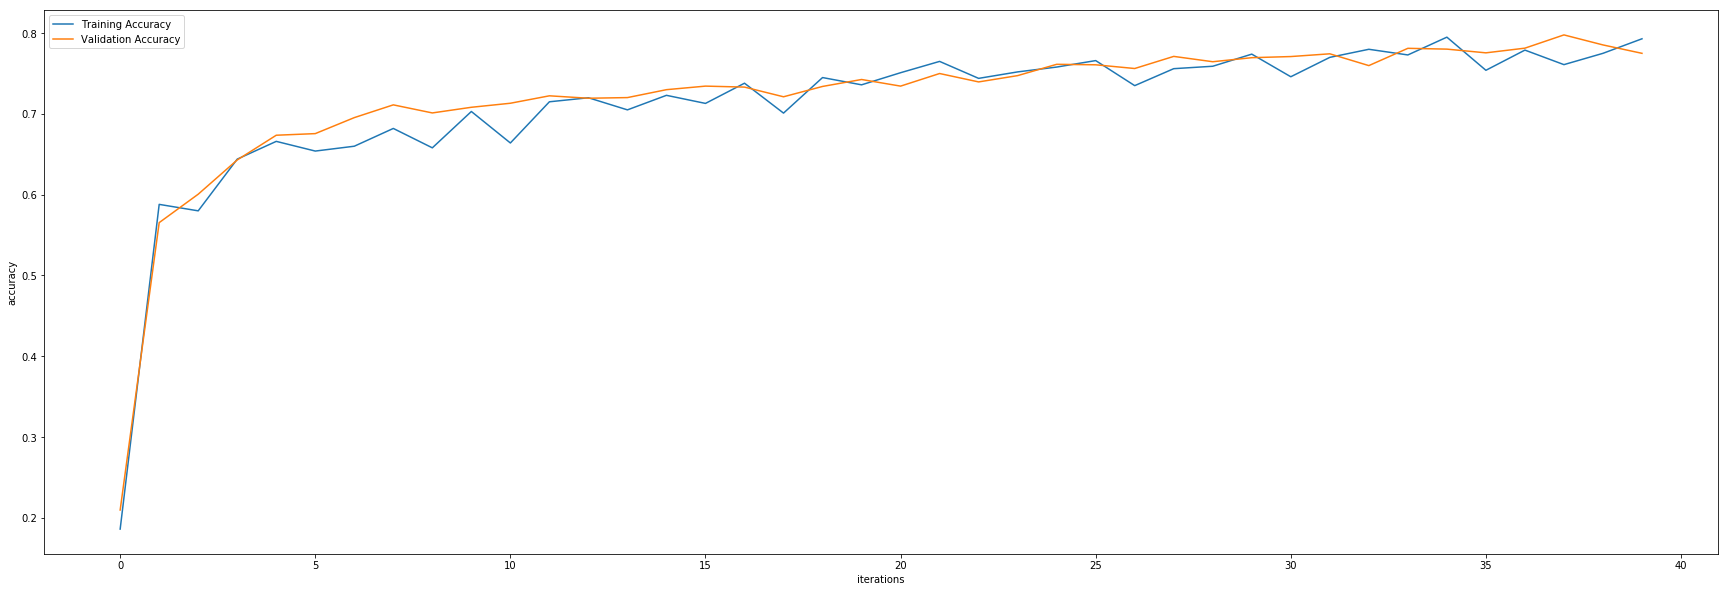

In [62]:
print("Final accuracy -itr%6d -train %5.2f test-%5.2f" % ( i, train_accs[-1], val_accs[-1]))

plt.figure(figsize=(30, 10))
plt.xlabel('iterations')
plt.ylabel('accuracy')
training_accuracy_line,=plt.plot(train_accs,label='Training Accuracy')
validation_accuracy_line,=plt.plot(val_accs,label='Validation Accuracy')
plt.legend(handles=[training_accuracy_line, validation_accuracy_line])

## Stride Experimentation - Single Stride 

In [66]:
class ConvNN_Single_stride(torch.nn.Module):
    def __init__(self):
        super(ConvNN_Single_stride,self).__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3,stride=1)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(32, 5, kernel_size=1)
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x
    

# Hyper Parameters for single stride

In [83]:
batch_size=60
NUM_OPT_STEPS=20000
# NUM_OPT_STEPS=train_labels.shape[0]/batch_size
learning_rate=1e-2

In [84]:
model=ConvNN_Single_stride()
print(model)
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)


ConvNN_Single_stride (
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (final_conv): Conv2d(32, 5, kernel_size=(1, 1), stride=(1, 1))
)


In [85]:
train_accs, val_accs = [], [] 
start=time.time()

for i in range(NUM_OPT_STEPS):
    train(batch_size)    
    if i % 100 == 0:
        train_accs.append(approx_accuracy(train_images,train_labels,1000))
        val_accs.append(approx_accuracy(validation_images,validation_labels))
    if i%1000 == 0:
        print("%6d %5.2f %5.2f" % ( i, train_accs[-1], val_accs[-1]))

end=time.time()
print('Time taken', end-start)

     0  0.19  0.20
  1000  0.84  0.81
  2000  0.86  0.86
  3000  0.83  0.84
  4000  0.85  0.87
  5000  0.89  0.89
  6000  0.84  0.88
  7000  0.92  0.90
  8000  0.90  0.89
  9000  0.92  0.89
 10000  0.89  0.89
 11000  0.92  0.91
 12000  0.89  0.91
 13000  0.89  0.91
 14000  0.91  0.90
 15000  0.93  0.91
 16000  0.91  0.91
 17000  0.89  0.89
 18000  0.92  0.91
 19000  0.91  0.92
('Time taken', 1362.1319358348846)


 19999  0.91  0.91


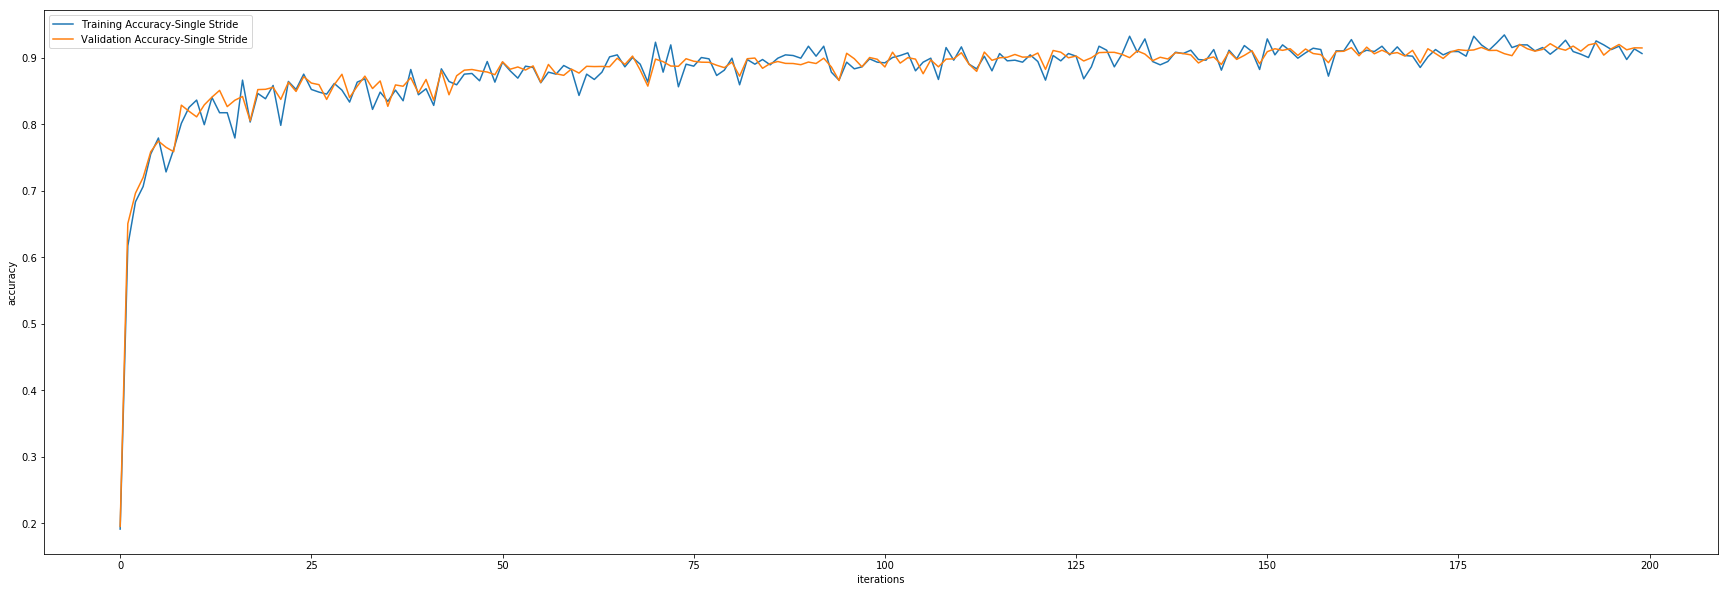

In [86]:
print("%6d %5.2f %5.2f" % ( i, train_accs[-1], val_accs[-1]))
plt.figure(figsize=(30, 10))
plt.xlabel('iterations')
plt.ylabel('accuracy')
training_accuracy_line,=plt.plot(train_accs,label='Training Accuracy-Single Stride')
validation_accuracy_line,=plt.plot(val_accs,label='Validation Accuracy-Single Stride')
plt.legend(handles=[training_accuracy_line, validation_accuracy_line])

# Stride Experimentation - Double Stride 

In [76]:
class ConvNN_Double_stride(torch.nn.Module):
    def __init__(self):
        super(ConvNN_Double_stride,self).__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3,stride=2)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=2)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(32, 5, kernel_size=1)
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x
    

# Hyper Parameters for Double stride

In [77]:
batch_size=60
NUM_OPT_STEPS=20000
# NUM_OPT_STEPS=train_labels.shape[0]/batch_size
learning_rate=1e-2

In [80]:
model=ConvNN_Double_stride()
print(model)
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)


ConvNN_Double_stride (
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (final_conv): Conv2d(32, 5, kernel_size=(1, 1), stride=(1, 1))
)


In [81]:
train_accs, val_accs = [], [] 
start=time.time()

for i in range(NUM_OPT_STEPS):
    train(batch_size)    
    if i % 100 == 0:
        train_accs.append(approx_accuracy(train_images,train_labels,1000))
        val_accs.append(approx_accuracy(validation_images,validation_labels))
    if i%1000 == 0:
        print("%6d %5.2f %5.2f" % ( i, train_accs[-1], val_accs[-1]))

end=time.time()
print('Time taken', end-start)

     0  0.18  0.19
  1000  0.82  0.83
  2000  0.84  0.85
  3000  0.83  0.83
  4000  0.85  0.86
  5000  0.87  0.86
  6000  0.86  0.87
  7000  0.86  0.86
  8000  0.87  0.88
  9000  0.89  0.87
 10000  0.89  0.89
 11000  0.88  0.87
 12000  0.90  0.88
 13000  0.90  0.88
 14000  0.90  0.88
 15000  0.89  0.87
 16000  0.87  0.88
 17000  0.91  0.88
 18000  0.89  0.88
 19000  0.89  0.87
('Time taken', 273.81437492370605)


 19999  0.91  0.87


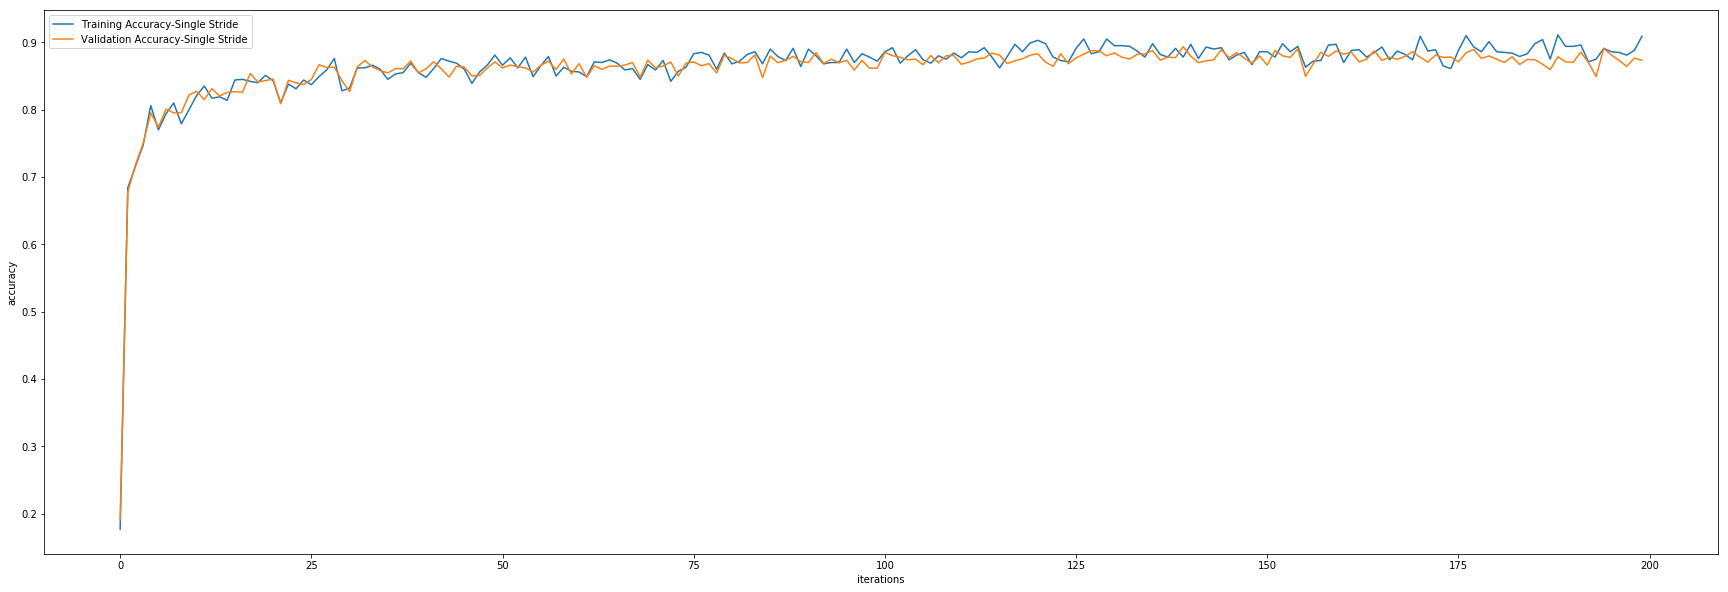

In [82]:
print("%6d %5.2f %5.2f" % ( i, train_accs[-1], val_accs[-1]))
plt.figure(figsize=(30, 10))
plt.xlabel('iterations')
plt.ylabel('accuracy')
training_accuracy_line,=plt.plot(train_accs,label='Training Accuracy-Single Stride')
validation_accuracy_line,=plt.plot(val_accs,label='Validation Accuracy-Single Stride')
plt.legend(handles=[training_accuracy_line, validation_accuracy_line])

# Reasoning

The best Validation Accuracy is: 0.90

Configuration: Single Stride CNN
TIME TAKEN: 868.31 seconds

Hyper Parameters 

    batch_size=60
    NUM_OPT_STEPS=20000
    learning_rate=1e-2    


Convolution networks learn our actiavtion maps are learning features and as we go deep , they start to learn more complex features so we could add more layers to improve our accuracy, thus learning newer features.

We are not over fitting or underfitting as both accracies are in same range.
